import numpy as np
from numpy import empty, zeros, ones, dot
from numpy.linalg import norm
import os
import time
import Video
import matplotlib
import matplotlib.pyplot as plt
from tools import IO, Image, Geom, Quat, Pattern, VideoStream, Projections
from tools.IO import read_ply,write_ply,write_obj
import cv2
import scipy.io as sio

In [15]:
import numpy as np
from numpy import empty, zeros, ones, dot 
from numpy.linalg import norm 
import os
import time
import Video
import matplotlib
import matplotlib.pyplot as plt
from tools import IO, Image, Geom, Quat, Pattern, VideoStream, Projections
from tools.IO import read_ply,write_ply,write_obj
import cv2
import scipy.io as sio

In [26]:
# seq = '/home/shubham/bb10/datasets/100/'
seq = '/home/shubham/datasets/paul_180_cap'
seq = '/home/shubham/datasets/steve_app_180'
seq = '/home/shubham/datasets/106_iphone/'
seq = '/home/shubham/datasets/hunter1'
# seq = '/home/shubham/bb10/datasets/vader'
# seq = '/home/shubham/bb10/datasets/face_allie'

results_path = os.path.join(seq,'sparse','results.npz')
if (os.path.isfile(results_path)):
    npz_sparse = np.load(results_path)
    im_size = tuple(npz_sparse['im_size'])
    cam0 = npz_sparse['cam']
    dist0 = npz_sparse['dist']
    Rs, ts = npz_sparse['Rs'], npz_sparse['ts']
    ws = npz_sparse['ws']
    pws = npz_sparse['pws']
    keyframe_inds = npz_sparse['frame_video_ids'].astype(np.int64)
    hosts= npz_sparse['point_host']
    ps = npz_sparse['ps']

else:
    print("results not found",results_path)
    exit()
stream = Video.load_color_stream(seq, cam0, dist0, levels=1, sigma=0.0, baselevel=0, buffer_size=1)

#
# stream = Video.load_greyscale_stream(
#     seq, start=0, sub=1, levels=3, sigma=max(0.5, 0.5), baselevel=0, look_for_cal=True)

#
cam, dist = stream.cam(0), stream.dist()
fx, fy, cx, cy = cam
K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
frames = stream.get_frames(keyframe_inds)
nF  = len(frames)

pba_vis = npz_sparse['visibility']
nF = ts.shape[0]
rs_array = np.zeros([3,1,nF])
ts_array = np.zeros([3,1,nF])
for i in range(nF):
    rs_array[:,:,i] = ws[i].reshape(3,1)
    ts_array[:,:,i] = ts[i].reshape(3,1)

[ 0.87399588  0.83912954  0.50024684  0.48631445]
Loading video from "/home/shubham/datasets/hunter1/imu.mp4"
get_frames: Reading 82 frames
  0          25         50         75         100
  |----------|----------|----------|----------|
  *********************************************



In [27]:
target_path = seq + '/cleaned_final3d_model.ply'
target,target_normals = IO.read_ply(target_path,return_faces=False,return_normals=True)
mesh_tformed,mesh_norms = IO.read_ply(seq + "/mesh_with_normals.ply")
# return

centre = np.mean(target,axis=0)
centre = np.mean(mesh_tformed,axis=0)
scale_factor = (np.linalg.norm(mesh_tformed[2087, :] - mesh_tformed[14471, :])) *2

target = target - centre -np.array([0,0,0.1])
target = target/scale_factor

Reading
Extracting
Reading
Extracting


In [28]:
def cart_to_cyl(T):
    C = np.zeros_like(T)
    C[:,2] = T[:,1]
    C[:,0] = np.sqrt(T[:,0]**2 + T[:,2]**2)
    C[:,1] = np.arccos(T[:,0]/C[:,0])
    C[np.where(T[:,2] < 0)[0],1] = 2*np.pi - C[np.where(T[:,2] < 0)[0],1]
    return C

def cyl_to_cart(T):
    C = np.zeros_like(T)
    C[:,1] = T[:,2]
    C[:,0] = np.cos(T[:,1])*T[:,0]
    C[:,2] = np.sqrt(T[:,0]**2 - C[:,0]**2)
    C[np.where((T[:,1]< (2*np.pi)) & (T[:,1]> (np.pi)) )[0],2] *=-1
#     neginds = np.where((np.pi/2 > T[:,1]))[0].tolist()
#     neginds +=  np.where (T[:,1]>(np.pi*3/2))[0].tolist()
#     C[np.where(T[:,1]> (np.pi))[0],2] *= -1
                       
    return C

In [29]:
face_cyl = cart_to_cyl(target)

In [30]:
minrho,mintheta,miny = np.min(face_cyl,axis=0)
maxrho,maxtheta,maxy = np.max(face_cyl,axis=0)
H=400
W=720
D = np.zeros([H,W])
D_median = np.zeros([H,W])

In [31]:
thetaspace = np.linspace(mintheta,maxtheta,W+1)
yspace = np.linspace(miny,maxy,H+1)
F = face_cyl.copy()
F = F[F[:,2].argsort()]

search_inds = np.searchsorted(F[:,2],yspace)

for x in range(W):
    for y in range(H):
        rmin,rmax = search_inds[y],search_inds[y+1]
        inds = np.where( (F[rmin:rmax+1,1] >= thetaspace[x]) & (F[rmin:rmax+1,1] <= thetaspace[x+1])&
                       (F[rmin:rmax+1,2]>=yspace[y]) & (F[rmin:rmax+1,2]<=yspace[y+1]) )[0] 
                        
        if(inds.size>0):
            D[y,x] = np.mean(F[rmin:rmax+1,:][inds,0])
            D_median[y,x] = np.median(F[rmin:rmax+1,:][inds,0])

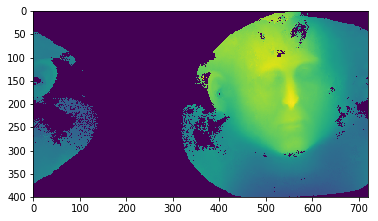

In [32]:
plt.imshow(D_median)
plt.show()

In [33]:
def fill_holes(D,W,H):
    for x in range(1,W-2):
        for y in range(H):
            if(D[y,x]!=0):
                continue
            else:
                if(D[y,x-1]==0):
                    continue
                if(D[y,x+1]!=0):
                    D[y,x] = (D[y,x-1] + D[y,x+1])/2
                elif(D[y,x+2]!=0):
                    diff = D[y,x+2]- D[y,x-1]
                    D[y,x] = D[y,x-1] + 0.333*diff
                    D[y,x+1] = D[y,x-1] + 0.667*diff
    return D


def mesh_dmap(D,thetaspace,yspace,W,H):
    verts = []
    idx = -1*np.ones([H,W],dtype=np.int32)
    tls =[]
    cnt =0
    for x in range(W-1):
        for y in range(H-1):
            if(D[y,x]!=0 and D[y+1,x+1]!=0):
                ystep = (yspace[y+1] - yspace[y])/2 ##will allow different resolutions in between, like say around nose
                tstep  = (thetaspace[x+1] - thetaspace[x])/2
                if(D[y,x+1]!=0):
                    for (a,b) in [(0,0),(0,1),(1,1)]:
                        if(idx[y+a,x+b]==-1):
                            verts.append([D[y+a,x+b],thetaspace[x+b] + tstep, yspace[y+a]+ystep])
                            cnt+=1
                            idx[y+a,x+b] =cnt

                    tls.append([idx[y,x],idx[y+1,x+1],idx[y,x+1]])

                if(D[y+1,x]!=0):
                    for (a,b) in [(0,0),(1,0),(1,1)]:
                        if(idx[y+a,x+b]==-1):
                            verts.append([D[y+a,x+b],thetaspace[x+b] + tstep, yspace[y+a]+ystep])
                            cnt+=1
                            idx[y+a,x+b] =cnt
                    tls.append([idx[y,x],idx[y+1,x],idx[y+1,x+1]])
    return verts,tls

In [34]:
D_median = fill_holes(D_median,720,400)
verts,tls = mesh_dmap(D_median,thetaspace=thetaspace,yspace=yspace,W=W,H=H)
print(len(verts))
vs = cyl_to_cart(np.array(verts))
write_ply(seq + '/cyl_to_vs_hunter1.ply',vs)
write_obj(seq+'/cyl_to_vs_hunter1.obj',vs,tls)

147759
write_ply done


In [25]:
seq

'/home/shubham/datasets/106_iphone/'